In [1]:
import ugradio
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import dish
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
from tqdm import tqdm, trange

No module named 'rtlsdr'


In [2]:
gal_b = []
gal_l = []
bs = np.arange(-70, -8, 2)
for b in bs:
    ls = np.arange(160, 220.1, 2/np.cos(b*np.pi/180))
    for l in ls:
        np.array(gal_b.append(b))
        np.array(gal_l.append(l))

In [3]:
x, y = np.meshgrid(gal_l, gal_b)

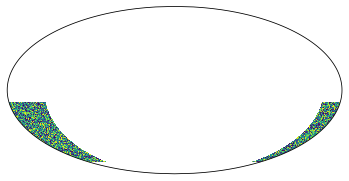

In [4]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mollweide()})

temp=np.random.rand(len(x),len(y)) #replace with real data
ax.imshow(temp,extent=[160,220,-70,-10], transform=ccrs.PlateCarree())

#TO-DO: rotate and crop

plt.grid()
plt.show()

In [5]:
def calibrate(data_nd0, data_nd1, pol):
    diff = np.array(data_nd1) - np.array(data_nd0)
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

In [6]:
def interp(data, L_t, B_t, L_m, B_m):
    spline = interp2d(L_m, B_m, data)
    t_interp = spline(L_t, B_t)
    return t_interp

In [7]:
#DO NOT RUN THIS CELL UNTIL DATA IS COLLECTED

size = 700
temp = np.empty((size, size))
l = np.linspace(160,220,size)
b = np.linspace(-70,-10,size)
L, B = np.meshgrid(l,b)

for i in range(size):
    for j in range(size):
        temp[i,j] = interp(temp, L[i], B[j], gal_l, gal_b)

NameError: name 'interp2d' is not defined

In [7]:
nfiles = 350
nspec = 50
nfreq = 8192

list_0 = np.empty((nfiles, nspec, nfreq))
list_1 = np.empty((nfiles, nspec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd0.fits')
    
    for j in range(nspec):
        
        list_0[i,j] = f[j+1].data['auto0_real']
        
        list_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 350/350 [01:14<00:00,  4.72it/s]


In [8]:
mean_specs_0 = np.mean(list_0, axis=1)
mean_specs_1 = np.mean(list_1, axis=1)

In [9]:
noise_spec = 5

noise_0 = np.empty((nfiles, noise_spec, nfreq))
noise_1 = np.empty((nfiles, noise_spec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd1.fits')
    
    for j in range(noise_spec):
        
        noise_0[i,j] = f[j+1].data['auto0_real']
        
        noise_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 350/350 [00:08<00:00, 43.75it/s]


In [10]:
mean_noise_0 = np.mean(noise_0, axis=1)
mean_noise_1 = np.mean(noise_1, axis=1)

In [11]:
tline_0 = calibrate(mean_specs_0, mean_noise_0, 0)
tline_1 = calibrate(mean_specs_1, mean_noise_1, 1)

<ipython-input-5-c29c21b26c69>:8: RuntimeWarning: divide by zero encountered in true_divide
  G = T/diff
<ipython-input-5-c29c21b26c69>:9: RuntimeWarning: invalid value encountered in multiply
  t_line = G * data_nd0


Text(0.5, 0.98, 'Test Data Power Spectra')

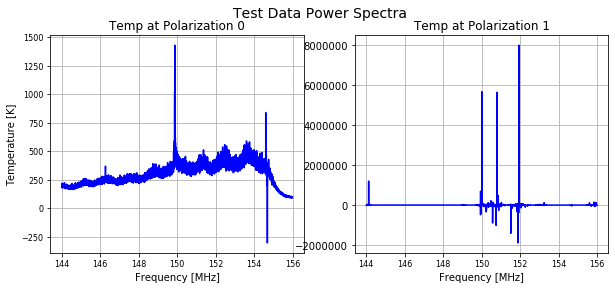

In [17]:
freq = np.linspace(144,156,8192)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,4))

ax1.plot(freq, tline_0[200], color='b')
ax1.set_title('Temp at Polarization 0', fontsize=12)
ax1.set_xlabel('Frequency [MHz]', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)
ax1.set_ylabel('Temperature [K]', fontsize=10)
ax1.grid()

ax2.plot(freq, tline_1[200], color='b')
ax2.set_title('Temp at Polarization 1', fontsize=12)
ax2.set_xlabel('Frequency [MHz]')
ax2.xaxis.set_tick_params(labelsize=8)
ax2.grid()

fig.suptitle('Test Data Power Spectra', fontsize=14)